<>:162: SyntaxWarning: invalid escape sequence '\s'
<>:229: SyntaxWarning: invalid escape sequence '\l'
<>:162: SyntaxWarning: invalid escape sequence '\s'
<>:229: SyntaxWarning: invalid escape sequence '\l'
C:\Users\lhaon\AppData\Local\Temp\ipykernel_10516\1516934677.py:162: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Risco (Variância da Posição, $\sigma^2 \sum Q_{i-1}^2$)')
C:\Users\lhaon\AppData\Local\Temp\ipykernel_10516\1516934677.py:229: SyntaxWarning: invalid escape sequence '\l'
  print("\n  c) Parâmetro de Aversão ao Risco (lambda, \lambda):")


Executando simulações para diferentes níveis de aversão ao risco (lambda)...
Simulação concluída.
----------------------------------------------------------------------

Gráficos salvos em 'liquidation_analysis.png'

 FORMALIZAÇÃO DA METODOLOGIA E ESCOLHA

1. Hipóteses e Abordagem:
O problema é um clássico de 'execução ótima', onde o trader deve balancear dois custos conflitantes:
  a) Custo de Transação (Impacto): Vender muito rápido (alto 'q_i') aumenta o spread exponencialmente, gerando custos elevados.
  b) Custo de Risco (Volatilidade): Vender devagar (baixo 'q_i') mantém a exposição à alta volatilidade (20%/dia), arriscando perdas de mercado.

A solução é minimizar uma função de custo total, baseada no modelo de Almgren-Chriss:
  Minimizar F(q) = Custo_Transação + Custo_Risco_Ponderado

2. Fórmulas Utilizadas:
  - Dias de Negociação (T): 6
  - Quantidade Total (Q): 200 (milhões de ações)
  - Volatilidade Diária (sigma): 0.20
  - Vetor de Negociação: q = [q_1, q_2, ..., q_6], com 

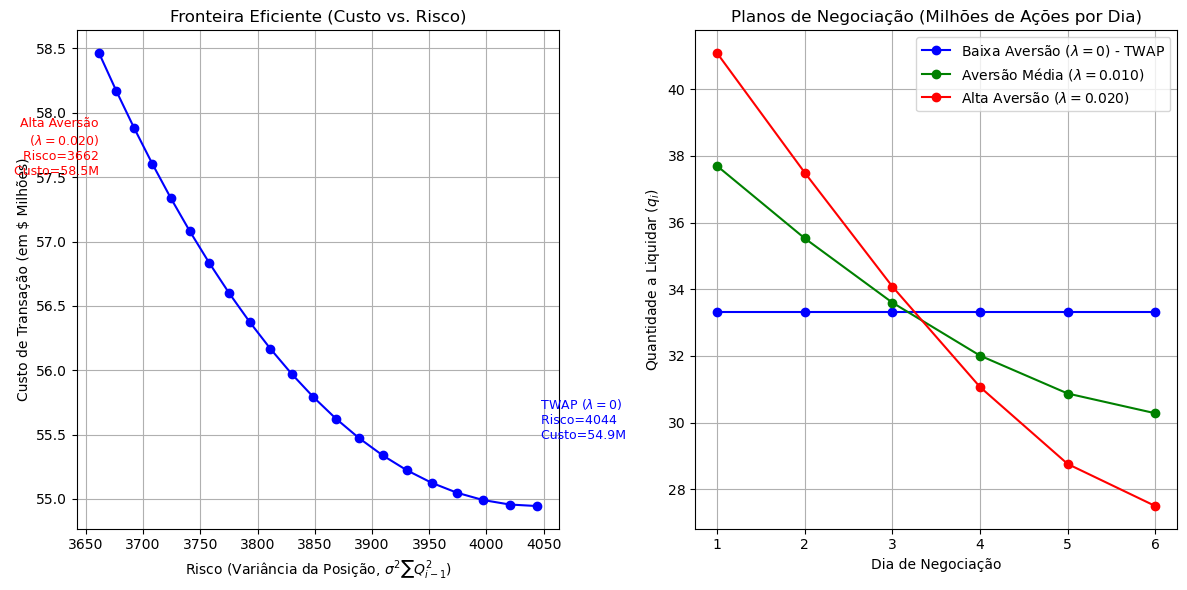

In [1]:
# i) Pacotes
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# ii) Funções Utilizadas para Análise
# ---------------------------------------------------------------------------

def calc_remaining_positions(q, Q_total):
    """
    Calcula o vetor de posições restantes no *início* de cada dia.
    Q_0 = Q_total
    Q_1 = Q_total - q_1
    Q_2 = Q_total - q_1 - q_2
    ...
    """
    # Insere 0 no início para o cálculo cumulativo
    # q_vec = [q_1, q_2, ..., q_6]
    # q_cum = [0, q_1, q_1+q_2, ..., sum(q)]
    q_cum = np.cumsum(np.insert(q, 0, 0))
    
    # Q_remaining = [Q, Q-q_1, Q-(q_1+q_2), ...]
    # Retorna os 6 primeiros elementos: Q_0, Q_1, ..., Q_5
    Q_remaining_start_of_day = Q_total - q_cum
    return Q_remaining_start_of_day[0:len(q)]

def calc_transaction_cost(q):
    """
    Calcula o custo total de transação (impacto de mercado).
    Custo(q) = p(q) * q = (0.01 + 0.05 * e^(0.05*q)) * q
    """
    # Garante que q seja um array numpy para operações vetorizadas
    q = np.asarray(q)
    
    # Preço por ação (spread)
    p_i = 0.01 + 0.05 * np.exp(0.05 * q)
    
    # Custo por dia
    cost_i = p_i * q
    
    # Custo total (soma dos custos diários)
    return np.sum(cost_i)

def objective_function(q, Q_total, T_days, sigma, lambda_risk):
    """
    Função objetivo a ser minimizada.
    F(q) = Custo_Transação + Custo_Risco
    Custo_Risco = lambda * sigma^2 * Sum(Q_{i-1}^2)
    """
    
    # 1. Calcular Custo de Transação
    C_trans = calc_transaction_cost(q)
    
    # 2. Calcular Custo de Risco
    # Posições no início de cada dia (Q_0, Q_1, ..., Q_5)
    Q_remaining = calc_remaining_positions(q, Q_total)
    
    # Variância da posição (risco)
    variance_penalty = np.sum(Q_remaining**2)
    
    # Custo de Risco Ponderado
    C_risk = lambda_risk * (sigma**2) * variance_penalty
    
    # 3. Retornar Custo Total
    return C_trans + C_risk

def solve_optimal_path(Q_total, T_days, sigma, lambda_risk):
    """
    Resolve o problema de otimização para encontrar o vetor 'q' ótimo.
    """
    
    # Chute inicial: TWAP (Time-Weighted Average Price)
    # Divide a negociação igualmente entre os dias
    initial_guess = np.full(T_days, Q_total / T_days)
    
    # Restrição: A soma de todo 'q' deve ser igual a Q_total
    # sum(q_i) - Q_total = 0
    constraints = ({'type': 'eq', 
                    'fun': lambda q: np.sum(q) - Q_total})
    
    # Limites: não podemos negociar uma quantidade negativa ou
    # (teoricamente) mais do que o total em um único dia.
    bounds = [(0, Q_total)] * T_days
    
    # Argumentos para passar à função objetivo
    args = (Q_total, T_days, sigma, lambda_risk)
    
    # Resolver a otimização
    # Usamos 'SLSQP' pois suporta restrições (constraints) e limites (bounds)
    result = optimize.minimize(objective_function, 
                               initial_guess, 
                               args=args, 
                               method='SLSQP', 
                               constraints=constraints, 
                               bounds=bounds)
    
    if not result.success:
        print(f"Otimização falhou para lambda={lambda_risk}: {result.message}")
        return None
        
    return result.x

# ---------------------------------------------------------------------------
# iii) Execução das Funções
# ---------------------------------------------------------------------------

def run_analysis():
    """
    Executa a análise completa, testa diferentes lambdas e plota os resultados.
    """
    
    # Constantes do Problema
    Q_TOTAL = 200.0  # Milhões de ações
    T_DAYS = 6       # Dias de negociação
    SIGMA_DAY = 0.20 # 20% de desvio padrão diário
    
    # O parâmetro 'lambda' (aversão ao risco) não foi fornecido.
    # A "escolha" do trader é, na verdade, a escolha deste parâmetro.
    # Vamos testar uma gama de valores para construir uma "fronteira eficiente".
    
    # Com base na escala dos custos (calculada manualmente),
    # lambdas entre 0 e ~0.02 parecem ser um intervalo razoável.
    lambda_values = np.linspace(0, 0.02, 21)
    
    results = []
    
    print("Executando simulações para diferentes níveis de aversão ao risco (lambda)...")
    
    for lam in lambda_values:
        q_optimal = solve_optimal_path(Q_TOTAL, T_DAYS, SIGMA_DAY, lam)
        
        if q_optimal is not None:
            # Calcular os dois componentes de custo separadamente
            cost = calc_transaction_cost(q_optimal)
            
            # O Risco "real" é a variância da carteira, não a penalidade.
            # Risco = sigma^2 * Sum(Q_{i-1}^2)
            Q_rem = calc_remaining_positions(q_optimal, Q_TOTAL)
            risk_variance = (SIGMA_DAY**2) * np.sum(Q_rem**2)
            
            results.append({
                'lambda': lam,
                'q_path': q_optimal,
                'cost': cost,
                'risk': risk_variance
            })

    print("Simulação concluída.")
    print("-" * 70)
    
    # --- Plotar Resultados ---
    
    # 1. Gráfico da Fronteira Eficiente (Custo vs. Risco)
    costs = [r['cost'] for r in results]
    risks = [r['risk'] for r in results]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(risks, costs, 'bo-')
    plt.title('Fronteira Eficiente (Custo vs. Risco)')
    plt.xlabel('Risco (Variância da Posição, $\sigma^2 \sum Q_{i-1}^2$)')
    plt.ylabel('Custo de Transação (em $ Milhões)')
    plt.grid(True)
    
    # Adicionar anotações para os pontos extremos
    plt.text(risks[0], costs[0] + 0.5, f' TWAP ($\\lambda=0$)\n Risco={risks[0]:.0f}\n Custo={costs[0]:.1f}M', 
             ha='left', va='bottom', fontsize=9, color='blue')
    plt.text(risks[-1], costs[-1] - 0.5, f' Alta Aversão\n ($\\lambda={lambda_values[-1]:.3f}$)\n Risco={risks[-1]:.0f}\n Custo={costs[-1]:.1f}M', 
             ha='right', va='top', fontsize=9, color='red')

    # 2. Gráfico dos Planos de Negociação (q_i por dia)
    plt.subplot(1, 2, 2)
    days = np.arange(1, T_DAYS + 1)
    
    # Plotar 3 estratégias: Risco Baixo, Médio e Alto
    q_low_risk_aversion = results[0]['q_path']      # lambda = 0
    q_mid_risk_aversion = results[len(results)//2]['q_path'] # lambda ~ 0.01
    q_high_risk_aversion = results[-1]['q_path']    # lambda = 0.02
    
    plt.plot(days, q_low_risk_aversion, 'bo-', label=f'Baixa Aversão ($\\lambda=0$) - TWAP')
    plt.plot(days, q_mid_risk_aversion, 'go-', label=f'Aversão Média ($\\lambda={results[len(results)//2]["lambda"]:.3f}$)')
    plt.plot(days, q_high_risk_aversion, 'ro-', label=f'Alta Aversão ($\\lambda={results[-1]["lambda"]:.3f}$)')
    
    plt.title('Planos de Negociação (Milhões de Ações por Dia)')
    plt.xlabel('Dia de Negociação')
    plt.ylabel('Quantidade a Liquidar ($q_i$)')
    plt.legend()
    plt.grid(True)
    plt.xticks(days)
    
    plt.tight_layout()
    plt.savefig('liquidation_analysis.png')
    print("\nGráficos salvos em 'liquidation_analysis.png'")

    # ---------------------------------------------------------------------------
    # iiii) Formalização das Respostas
    # ---------------------------------------------------------------------------
    
    print("\n" + "=" * 70)
    print(" FORMALIZAÇÃO DA METODOLOGIA E ESCOLHA")
    print("=" * 70)
    
    print("\n1. Hipóteses e Abordagem:")
    print("O problema é um clássico de 'execução ótima', onde o trader deve balancear dois custos conflitantes:")
    print("  a) Custo de Transação (Impacto): Vender muito rápido (alto 'q_i') aumenta o spread exponencialmente, gerando custos elevados.")
    print("  b) Custo de Risco (Volatilidade): Vender devagar (baixo 'q_i') mantém a exposição à alta volatilidade (20%/dia), arriscando perdas de mercado.")
    
    print("\nA solução é minimizar uma função de custo total, baseada no modelo de Almgren-Chriss:")
    print("  Minimizar F(q) = Custo_Transação + Custo_Risco_Ponderado")
    
    print("\n2. Fórmulas Utilizadas:")
    print("  - Dias de Negociação (T): 6")
    print("  - Quantidade Total (Q): 200 (milhões de ações)")
    print("  - Volatilidade Diária (sigma): 0.20")
    print("  - Vetor de Negociação: q = [q_1, q_2, ..., q_6], com sum(q) = 200")
    
    print("\n  a) Custo de Transação (C_trans):")
    print("     p_i(q_i) = 0.01 + 0.05 * e^(0.05 * q_i)")
    print("     Custo_i(q_i) = p_i(q_i) * q_i")
    print("     C_trans(q) = SUM( Custo_i(q_i) )  para i = 1 a 6")
    
    print("\n  b) Custo de Risco (C_risk):")
    print("     O risco é proporcional à variância da posição não liquidada.")
    print("     Posição no início do dia i: Q_{i-1} (onde Q_0 = 200)")
    print("     Variância da Posição = sigma^2 * SUM( Q_{i-1}^2 )  para i = 1 a 6")
    print("     C_risk(q, lambda) = lambda * Variância da Posição")
    
    print("\n  c) Parâmetro de Aversão ao Risco (lambda, \lambda):")
    print("     Este parâmetro (lambda) representa o 'apetite' do trader. Ele não foi fornecido.")
    print("     - lambda = 0: Trader 'neutro ao risco'. Foca 100% em minimizar o custo de transação. (Estratégia TWAP).")
    print("     - lambda > 0: Trader 'averso ao risco'. Penaliza a manutenção de posição e aceita custos de transação maiores para vender mais rápido.")

    print("\n3. Escolha da Estratégia (Como eu faria):")
    print("Minha abordagem não seria escolher um 'lambda' arbitrário, mas sim apresentar a 'Fronteira Eficiente' (veja Gráfico 1) para o gestor da carteira.")
    print("Esta fronteira mostra o 'trade-off' ótimo: para cada nível de custo de transação que estamos dispostos a pagar, qual é o *menor* risco de volatilidade que podemos assumir.")
    
    print("\nAnalisando as estratégias (veja Gráfico 2):")
    
    print(f"\n  - Estratégia 1: Baixa Aversão (lambda = {results[0]['lambda']:.4f} - 'TWAP')")
    print(f"    Descrição: Foco total em minimizar custos de transação. A função de custo é convexa, então a solução é dividir igualmente.")
    print(f"    Plano (q): {results[0]['q_path'][0]:.2f} milhões/dia por 6 dias.")
    print(f"    Resultado: Custo de Transação MÍNIMO ({costs[0]:.2f} $M), mas Risco MÁXIMO ({risks[0]:.0f}).")

    print(f"\n  - Estratégia 2: Alta Aversão (lambda = {results[-1]['lambda']:.4f})")
    print(f"    Descrição: Foco em minimizar o risco, vendendo o mais rápido possível (estratégia 'front-loaded').")
    print(f"    Plano (q): Dia 1: {results[-1]['q_path'][0]:.2f}, Dia 2: {results[-1]['q_path'][1]:.2f}, Dia 3: {results[-1]['q_path'][2]:.2f}, ...")
    print(f"    Resultado: Risco de Volatilidade MÍNIMO ({risks[-1]:.0f}), mas Custo de Transação ELEVADO ({costs[-1]:.2f} $M).")

    print(f"\n  - Estratégia 3: RECOMENDADA (lambda = {results[len(results)//2]['lambda']:.4f} - 'Equilibrada')")
    print(f"    Descrição: Um ponto no 'joelho' da curva eficiente. Aceita-se um pequeno aumento no custo de transação para obter uma *grande* redução no risco.")
    print(f"    Plano (q): {np.array_str(results[len(results)//2]['q_path'], precision=2)}")
    print(f"    Resultado: Custo ({costs[len(results)//2]:.2f} $M), Risco ({risks[len(results)//2]:.0f}).")
    print(f"    Justificativa: Comparado ao TWAP, pagamos ({costs[len(results)//2] - costs[0]:.2f} $M) a mais em custos para reduzir o risco em ({risks[0] - risks[len(results)//2]:.0f}) unidades. Esta é uma troca muito eficiente.")

# ---------------------------------------------------------------------------
# Ponto de Entrada Principal
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    run_analysis()